In [1]:
import os
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, mean_absolute_error
from utilities import cal_score, cal_mape, cal_score_smooth

In [2]:
stack_idx = '18'
models = '1-10,12-22,24-29'
use_test_kfold = set([2, 7, 8, 12, 13])

is_per_area = True
add_intercept = True

### Read CV predictions and test

In [3]:
def parse_models(exp):
    exp_split = exp.split(',')
    idx_models = []
    for e in exp_split:
        if '-' in e:
            n0, n1 = e.split('-')
            idx_models.extend(list(range(int(n0), int(n1)+1, 1)))
        else:
            idx_models.append(int(e))
    return idx_models

In [4]:
idx_models = parse_models(models)
print(idx_models)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29]


In [5]:
files_in_output = [f for f in os.listdir('output/') if os.path.isfile('output/'+f)]
files_cv = {idx: [f for f in files_in_output 
                  if f.startswith('model-%02d-' % idx) and f.endswith('cv.csv')][0] 
            for idx in idx_models}
files_test_one = {idx: [f for f in files_in_output 
                        if f.startswith('model-%02d-' % idx) and f.endswith('test-one.csv')][0]
                  for idx in idx_models}
files_test_kf = {idx: [f for f in files_in_output 
                       if f.startswith('model-%02d-' % idx) and f.endswith('test-kfold.csv')][0]
                 for idx in idx_models}

In [6]:
for k in files_cv: 
    print('%2d'%k, files_cv[k])
    print('%2d'%k, files_test_kf[k])
    print('%2d'%k, files_test_one[k])

 1 model-01-lgb-cv.csv
 1 model-01-lgb-test-kfold.csv
 1 model-01-lgb-test-one.csv
 2 model-02-keras-search-cv.csv
 2 model-02-keras-search-test-kfold.csv
 2 model-02-keras-search-test-one.csv
 3 model-03-lgb-feats-selection-cv.csv
 3 model-03-lgb-feats-selection-test-kfold.csv
 3 model-03-lgb-feats-selection-test-one.csv
 4 model-04-lgb-PCA-cv.csv
 4 model-04-lgb-PCA-test-kfold.csv
 4 model-04-lgb-PCA-test-one.csv
 5 model-05-lgb-wo-per-area-cv.csv
 5 model-05-lgb-wo-per-area-test-kfold.csv
 5 model-05-lgb-wo-per-area-test-one.csv
 6 model-06-lgb-lr0.001-cv.csv
 6 model-06-lgb-lr0.001-test-kfold.csv
 6 model-06-lgb-lr0.001-test-one.csv
 7 model-07-keras-embedding-cv.csv
 7 model-07-keras-embedding-test-kfold.csv
 7 model-07-keras-embedding-test-one.csv
 8 model-08-keras-search-long-cv.csv
 8 model-08-keras-search-long-test-kfold.csv
 8 model-08-keras-search-long-test-one.csv
 9 model-09-lgb-feats-selection-75-cv.csv
 9 model-09-lgb-feats-selection-75-test-kfold.csv
 9 model-09-lgb-fea

#### Load area

In [7]:
df_train = pd.read_csv('dataset/train.csv')
df_test = pd.read_csv('dataset/test.csv')

In [8]:
cv = df_train[['building_id', 'building_area', 'total_price']]
test = df_test[['building_id', 'building_area']]

In [9]:
print('CV predictions:')
print(len(idx_models))
for i, idx_model in enumerate(idx_models):
    f = files_cv[idx_model]
    print(f)
#    print('No. {} file: {}'.format(i, f))
    df = pd.read_csv('output/'+f)
    
    cv = pd.merge(cv, df[['building_id', 'total_price_predict']], on='building_id')
    
    cv = cv.rename(columns = {'total_price_predict': 'pred_{}'.format(idx_model)})
    cv[f'log_pred_{idx_model}'] = np.log1p(cv[f'pred_{idx_model}'])
    cv[f'log_parea_pred_{idx_model}'] = np.log1p( cv[f'pred_{idx_model}'] / cv['building_area'] )

CV predictions:
27
model-01-lgb-cv.csv
model-02-keras-search-cv.csv
model-03-lgb-feats-selection-cv.csv
model-04-lgb-PCA-cv.csv
model-05-lgb-wo-per-area-cv.csv
model-06-lgb-lr0.001-cv.csv
model-07-keras-embedding-cv.csv
model-08-keras-search-long-cv.csv
model-09-lgb-feats-selection-75-cv.csv
model-10-lgb-feats-selection-75-lr-0.001-cv.csv
model-12-predict-keras-search-prelu-cv.csv
model-13-predict-keras-he_uni-cv.csv
model-14-lgb-feats-selection-75-lr-0.001-rand-cv.csv
model-15-lgb-feats-selection-75-lr-0.001-rand323-cv.csv
model-16-lgb-feats-selection-68-lr-0.001-mix5-cv.csv
model-17-lgb-feats-selection-70-lr-0.001-mix5-cv.csv
model-18-lgb-feats-selection-70-lr-0.001-p5-cv.csv
model-19-lgb-search-bins-lr-0.0005-cv.csv
model-20-lgb-lr-0.0008-mix5-cv.csv
model-21-lgb-wo-per-area-long-cv.csv
model-22-lgb-wo-per-area-long-2-cv.csv
model-24-lgb-binary-augment-cv.csv
model-25-lgb-search-bins-lr-0.0005-250-cv.csv
model-26-lgb-search-bins-lr-0.0005-350-cv.csv
model-27-lgb-feat_rm_new-cv.csv
m

In [10]:
cv['log_total_price'] = np.log1p(cv['total_price'])
cv['log_parea_total_price'] = np.log1p( cv['total_price'] / cv['building_area'] )

print('Test predictions:')
for i, idx in enumerate(idx_models):
    f = files_test_kf[idx] if idx in use_test_kfold else files_test_one[idx]
    print('No. {} file: {}'.format(i, f))
    df = pd.read_csv('output/'+f)

    test = pd.merge(test, df[['building_id','total_price']], on='building_id')
        
    test = test.rename(columns = {'total_price': 'pred_{}'.format(idx)})
    test[f'log_pred_{idx}'] = np.log1p(test[f'pred_{idx}'])
    test[f'log_parea_pred_{idx}'] = np.log1p( test[f'pred_{idx}'] / test['building_area'] )

Test predictions:
No. 0 file: model-01-lgb-test-one.csv
No. 1 file: model-02-keras-search-test-kfold.csv
No. 2 file: model-03-lgb-feats-selection-test-one.csv
No. 3 file: model-04-lgb-PCA-test-one.csv
No. 4 file: model-05-lgb-wo-per-area-test-one.csv
No. 5 file: model-06-lgb-lr0.001-test-one.csv
No. 6 file: model-07-keras-embedding-test-kfold.csv
No. 7 file: model-08-keras-search-long-test-kfold.csv
No. 8 file: model-09-lgb-feats-selection-75-test-one.csv
No. 9 file: model-10-lgb-feats-selection-75-lr-0.001-test-one.csv
No. 10 file: model-12-predict-keras-search-prelu-test-kfold.csv
No. 11 file: model-13-predict-keras-he_uni-test-kfold.csv
No. 12 file: model-14-lgb-feats-selection-75-lr-0.001-rand-test-one.csv
No. 13 file: model-15-lgb-feats-selection-75-lr-0.001-rand323-test-one.csv
No. 14 file: model-16-lgb-feats-selection-68-lr-0.001-mix5-test-one.csv
No. 15 file: model-17-lgb-feats-selection-70-lr-0.001-mix5-test-one.csv
No. 16 file: model-18-lgb-feats-selection-70-lr-0.001-p5-test

In [11]:
display(cv.head())
display(test.head())

,building_id,building_area,total_price,pred_1,log_pred_1,log_parea_pred_1,pred_2,log_pred_2,log_parea_pred_2,pred_3,...,log_pred_27,log_parea_pred_27,pred_28,log_pred_28,log_parea_pred_28,pred_29,log_pred_29,log_parea_pred_29,log_total_price,log_parea_total_price
0,e3mMIMR3JJqCaXz1,3.418175,6.476038e+05,6.331552e+05,13.358472,12.129369,717209.94,13.483125,12.254022,6.656891e+05,...,13.381324,12.152221,6.374413e+05,13.365219,12.136116,6.274171e+05,13.349368,12.120265,13.381036,12.151933
1,LgwzgklNvy4QCtq5,4.041309,3.321452e+06,3.064324e+06,14.935338,13.538770,2899842.20,14.880167,13.483600,3.079196e+06,...,14.955716,13.559149,3.160098e+06,14.966114,13.569546,3.145481e+06,14.961478,13.564910,15.015913,13.619345
2,ucIR2NLLsC3T650L,5.584279,9.570885e+06,9.827776e+06,16.100723,14.380769,9766813.00,16.094501,14.374546,9.814852e+06,...,16.092359,14.372404,9.804749e+06,16.098377,14.378423,9.762486e+06,16.094058,14.374103,16.074236,14.354282
3,jre1pJhcQj91Kdky,13.563031,1.421501e+07,1.255350e+07,16.345510,13.738164,12699800.00,16.357097,13.749750,1.255981e+07,...,16.348848,13.741502,1.263065e+07,16.351637,13.744290,1.262574e+07,16.351248,13.743901,16.469809,13.862462
4,rQpYpY9nRG7X5mmr,4.688108,7.627120e+05,1.215194e+06,14.010415,12.465389,2012610.50,14.514944,12.969916,1.128419e+06,...,13.938992,12.393966,1.132637e+06,13.940060,12.395034,1.128514e+06,13.936413,12.391388,13.544637,11.999613


,building_id,building_area,pred_1,log_pred_1,log_parea_pred_1,pred_2,log_pred_2,log_parea_pred_2,pred_3,log_pred_3,...,log_parea_pred_26,pred_27,log_pred_27,log_parea_pred_27,pred_28,log_pred_28,log_parea_pred_28,pred_29,log_pred_29,log_parea_pred_29
0,X5gsdTWGS3W7JJQB,3.418175,1.526912e+07,16.541343,15.312236,12470072.0,16.338842,15.109735,1.531685e+07,16.544464,...,15.195091,1.405424e+07,16.458435,15.229328,1.485198e+07,16.513644,15.284537,1.458851e+07,16.495745,15.266638
1,BTshNOJyKHnT2YIT,7.726227,3.924241e+06,15.182684,13.138065,3916552.2,15.180723,13.136104,3.977095e+06,15.196062,...,13.135851,3.932854e+06,15.184876,13.140257,3.925095e+06,15.182901,13.138282,3.930381e+06,15.184247,13.139628
2,dhdymr0lV8N5kZOT,12.170581,1.096127e+07,16.209879,13.710858,11912735.0,16.293119,13.794098,1.084967e+07,16.199646,...,13.692710,1.040041e+07,16.157355,13.658335,1.066340e+07,16.182328,13.683307,1.053625e+07,16.170332,13.671312
3,VEwyGGMcD56w5BOc,2.252256,6.155550e+06,15.632865,14.820933,5940670.0,15.597333,14.785400,6.015238e+06,15.609807,...,14.801146,5.905111e+06,15.591329,14.779397,6.025775e+06,15.611557,14.799625,5.922934e+06,15.594343,14.782410
4,wmUeMoJZfsqaSX9b,5.813985,1.062995e+06,13.876602,12.116340,1088488.1,13.900301,12.140039,1.027248e+06,13.842395,...,12.147091,1.048505e+06,13.862877,12.102615,1.078927e+06,13.891479,12.131217,1.092658e+06,13.904125,12.143863


### Check models scores

In [12]:
for i, idx_model in enumerate(idx_models):
    print('%2d'%i, 'model-%02d'%idx_model, '%.6f'%cal_score(cv['total_price'], cv[f'pred_{idx_model}']))

 0 model-01 5870.873059
 1 model-02 5400.852164
 2 model-03 5877.873452
 3 model-04 5713.867808
 4 model-05 5724.869598
 5 model-06 5886.873769
 6 model-07 5171.836449
 7 model-08 5514.858826
 8 model-09 5872.873118
 9 model-10 5897.873845
10 model-12 5486.856963
11 model-13 5506.858055
12 model-14 5908.873901
13 model-15 5900.873836
14 model-16 5907.874126
15 model-17 5905.874165
16 model-18 5908.874297
17 model-19 5911.874156
18 model-20 5908.874040
19 model-21 5758.870702
20 model-22 5752.870671
21 model-24 5866.873835
22 model-25 5908.874238
23 model-26 5918.873998
24 model-27 5892.873194
25 model-28 5901.874202
26 model-29 5884.873848


In [13]:
cv['constant_1'] = 1
test['constant_1'] = 1

if is_per_area:
    cols_opt = [f'log_parea_pred_{idx}' for idx in idx_models]
else:
    cols_opt = [f'log_pred_{idx}' for idx in idx_models]

if add_intercept:
    cols_opt.append('constant_1')

### Define opt function

In [14]:
def objective(x, cv, metric, best_score, best_coeffs, verbose):
    cv_pred_final = cv[cols_opt].dot(x)
    
    if is_per_area:
        cv_pred_final = np.expm1(cv_pred_final) * cv['building_area']
    else:
        cv_pred_final = np.expm1(cv_pred_final)

    score = cal_score(cv['total_price'], cv_pred_final)
    if score > best_score[metric]:
        best_score[metric] = score
        best_coeffs[metric] = x.copy()
        if verbose:
            print('find better score:')
            print('score: ', score)
            print('coeffs: ', x)
            print()
    
    if metric == 'mape':
        return cal_mape(cv['total_price'], cv_pred_final)
    elif metric == 'mse':
        return mean_squared_error(cv['total_price'], cv_pred_final)
    elif metric == 'mae':
        return mean_absolute_error(cv['total_price'], cv_pred_final)
    elif metric == 'smooth':
        return cal_score_smooth(cv['total_price'], cv_pred_final)
    else:
        raise Exception('metric unknown: {}'.format(metric))
#    return 1 - (cal_score(cv['total_price'], cv_pred_final)/10000)

### CV

In [16]:
from sklearn.model_selection import KFold

cv = cv.reset_index(drop=True)
#cv = cv.head(100)

len_x = len(cols_opt)
rev_len_x = 1/len_x
# x0s = [[1/len_x for i in range(len_x)],
#        [0 for i in range(len_x)],
#        [0.1 for i in range(len_x)],
#        [0.2 for i in range(len_x)],
#        [0.5 for i in range(len_x)],
#        (np.random.randn(len_x)+1)/len_x,
#        (np.random.randn(len_x)+1)/len_x,
#        (np.random.randn(len_x)+1)/len_x,
#       ]
x0s = [[-0.06481832,  0.02029489,  0.01150214, -0.01645597,  0.14834533,
         0.06523757,  0.02456909,  0.11477938,  0.00673978, -0.0700295 ,
        -0.00412752,  0.05089771, -0.12394792, -0.06902084,  0.05570669,
         0.14328919,  0.15403292,  0.0679902 , -0.11814277, -0.01753184,
        -0.03442738,  0.25283254,  0.01972977,  0.30131045,  0.29102463,
        -0.09054672, -0.11219087, -0.09960696]]
bounds = tuple([(0, 1) for i in range(len_x-1)] + [(-2, 2)])

score_list = []

kf = KFold(shuffle= True, n_splits=5)
kfold_coeffs = []
for i_fold, (idx_train, idx_val) in enumerate(kf.split(cv)):
    print('== Fold', i_fold, '==')

    best_score = {}
    best_coeffs = {}
    
    cv_fold_train = cv.loc[idx_train].reset_index(drop=True)
    cv_fold_val = cv.loc[idx_train].reset_index(drop=True)
    
    for metric in ['smooth']:
    #for metric in ['mape', 'mae', 'mse']:
        best_score[metric] = 0
        best_coeffs[metric] = []
        for x0 in x0s:
            print('Optimizing with init x0: {}'.format(x0))
            print()
            minimize(objective, x0, args=(cv_fold_train, metric, best_score, best_coeffs, 
                                          True), 
                     tol=1e-4) #, bounds=bounds
    
    val_pred_final = cv_fold_val[cols_opt].dot(best_coeffs['smooth'])
    if is_per_area:
        val_pred_final = np.expm1(val_pred_final) * cv_fold_val['building_area']
    else:
        val_pred_final = np.expm1(val_pred_final)
    score = cal_score(cv_fold_val['total_price'], val_pred_final)
    
    score_list.append(score)
    kfold_coeffs.append(best_coeffs)

print('CV score ?: {}; {}'.format(np.mean(score_list), score_list))
print(kfold_coeffs)

Optimizing with init x0: [-0.06481832, 0.02029489, 0.01150214, -0.01645597, 0.14834533, 0.06523757, 0.02456909, 0.11477938, 0.00673978, -0.0700295, -0.00412752, 0.05089771, -0.12394792, -0.06902084, 0.05570669, 0.14328919, 0.15403292, 0.0679902, -0.11814277, -0.01753184, -0.03442738, 0.25283254, 0.01972977, 0.30131045, 0.29102463, -0.09054672, -0.11219087, -0.09960696]

find better score:
score:  5965.876461239726
coeffs:  [-0.06481832  0.02029489  0.01150214 -0.01645597  0.14834533  0.06523757
  0.02456909  0.11477938  0.00673978 -0.0700295  -0.00412752  0.05089771
 -0.12394792 -0.06902084  0.05570669  0.14328919  0.15403292  0.0679902
 -0.11814277 -0.01753184 -0.03442738  0.25283254  0.01972977  0.30131045
  0.29102463 -0.09054672 -0.11219087 -0.09960696]

find better score:
score:  5965.8764833027335
coeffs:  [-0.0645798   0.01832825  0.01203609 -0.01410827  0.15022769  0.06595738
  0.02476802  0.11442379  0.00736642 -0.07120233 -0.00121609  0.04961483
 -0.12534179 -0.0697512   0.05

find better score:
score:  5980.876962697314
coeffs:  [-0.0648629   0.02040112  0.01148935 -0.01625579  0.14849711  0.06521113
  0.02456576  0.11476483  0.00673627 -0.07006272 -0.00411199  0.05066588
 -0.12399126 -0.06906686  0.05568881  0.14328405  0.1540416   0.06796977
 -0.11818441 -0.01740752 -0.03429073  0.25277891  0.01971484  0.30133729
  0.29096636 -0.09059241 -0.11222983 -0.09962283]

find better score:
score:  5980.8769654521875
coeffs:  [-0.06504315  0.02082412  0.01143626 -0.01545702  0.14910229  0.06510346
  0.02455051  0.11470471  0.00672029 -0.07019751 -0.00405176  0.04973668
 -0.12416651 -0.06925284  0.0556154   0.14326156  0.15407442  0.06788615
 -0.11835287 -0.01691218 -0.03374605  0.25256249  0.01965322  0.30144275
  0.29073137 -0.09077705 -0.1123876  -0.09968642]

find better score:
score:  5980.876975735753
coeffs:  [-0.06576413  0.02251611  0.01122391 -0.01226193  0.151523    0.06467279
  0.02448953  0.11446425  0.00665641 -0.07073669 -0.00381087  0.04601987
 -0.1

In [57]:
print(np.array([x['smooth'] for x in kfold_coeffs]).mean(axis=0))

[-0.06786926  0.01771568  0.00374394 -0.00730682  0.15047118  0.07709944
  0.0193351   0.11644108  0.00154198 -0.07535779  0.00238193  0.04652346
 -0.15880333 -0.01627637  0.05318755  0.21013744  0.10778093  0.04730017
 -0.22011455 -0.02240898 -0.0211158   0.27380756  0.03942869  0.35826631
  0.29595179 -0.12347784 -0.10082817 -0.10657424]


In [20]:
import matplotlib.pyplot as plt

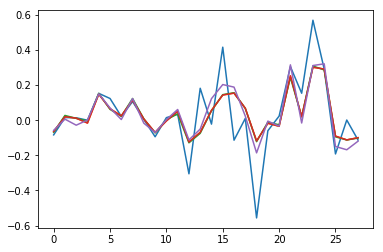

In [21]:
for row in kfold_coeffs:
    plt.plot(row['smooth'])
plt.show()

### Ensemble Scores

In [37]:
cv.check()

,building_id,building_area,total_price,pred_1,log_pred_1,log_parea_pred_1,pred_2,log_pred_2,log_parea_pred_2,pred_3,...,log_parea_pred_27,pred_28,log_pred_28,log_parea_pred_28,pred_29,log_pred_29,log_parea_pred_29,log_total_price,log_parea_total_price,constant_1
0,e3mMIMR3JJqCaXz1,3.418175,6.476038e+05,6.331552e+05,13.358472,12.129369,717209.94,13.483125,12.254022,6.656891e+05,...,12.152221,6.374413e+05,13.365219,12.136116,6.274171e+05,13.349368,12.120265,13.381036,12.151933,1
1,LgwzgklNvy4QCtq5,4.041309,3.321452e+06,3.064324e+06,14.935338,13.538770,2899842.20,14.880167,13.483600,3.079196e+06,...,13.559149,3.160098e+06,14.966114,13.569546,3.145481e+06,14.961478,13.564910,15.015913,13.619345,1
2,ucIR2NLLsC3T650L,5.584279,9.570885e+06,9.827776e+06,16.100723,14.380769,9766813.00,16.094501,14.374546,9.814852e+06,...,14.372404,9.804749e+06,16.098377,14.378423,9.762486e+06,16.094058,14.374103,16.074236,14.354282,1
3,jre1pJhcQj91Kdky,13.563031,1.421501e+07,1.255350e+07,16.345510,13.738164,12699800.00,16.357097,13.749750,1.255981e+07,...,13.741502,1.263065e+07,16.351637,13.744290,1.262574e+07,16.351248,13.743901,16.469809,13.862462,1
4,rQpYpY9nRG7X5mmr,4.688108,7.627120e+05,1.215194e+06,14.010415,12.465389,2012610.50,14.514944,12.969916,1.128419e+06,...,12.393966,1.132637e+06,13.940060,12.395034,1.128514e+06,13.936413,12.391388,13.544637,11.999613,1
59995,Oh5Hwr9LrWApC2mr,6.754060,9.870214e+05,1.462514e+06,14.195668,12.285528,1096943.80,13.908039,11.997901,1.450595e+06,...,12.308562,1.469145e+06,14.200192,12.290052,1.476790e+06,14.205382,12.295242,13.802448,11.892310,1
59996,PiOgZqfsDVlTq1zs,5.356788,1.572522e+07,1.419424e+07,16.468347,14.789983,16524961.00,16.620383,14.942018,1.488475e+07,...,14.816436,1.467994e+07,16.501992,14.823628,1.414342e+07,16.464760,14.786396,16.570777,14.892412,1
59997,FQmlgGohzzWuKUzu,8.223644,1.181540e+07,1.264280e+07,16.352598,14.245585,12099525.00,16.308677,14.201664,1.259087e+07,...,14.243286,1.261569e+07,16.350452,14.243439,1.293758e+07,16.375647,14.268634,16.284915,14.177902,1
59998,zjzfMwXhDswdEaI2,8.728287,1.808500e+07,1.742945e+07,16.673672,14.507103,18142848.00,16.713787,14.547218,1.685909e+07,...,14.491942,1.737928e+07,16.670789,14.504220,1.740258e+07,16.672129,14.505560,16.710593,14.544025,1
59999,iN4H6wBMtvJpF0SN,5.356788,8.510296e+06,8.053811e+06,15.901656,14.223292,8046627.00,15.900764,14.222400,8.183993e+06,...,14.239996,8.203092e+06,15.920022,14.241658,8.260346e+06,15.926977,14.248613,15.956787,14.278423,1


shape = (60000, 87)


In [39]:
for i, best_coeffs in enumerate(kfold_coeffs):
    cv['log_fold_%d'%i] = cv.loc[:, cols_opt].dot(best_coeffs['smooth'])

In [44]:
cv['log_parea_total_price_ens_pred'] = cv.loc[
    :, ['log_fold_%d'%i for i in range(len(kfold_coeffs))]
].mean(axis=1)

In [45]:
if is_per_area:
    cv['total_price_ens_pred'] = np.expm1(cv['log_parea_total_price_ens_pred']) * cv['building_area'] 
else:
    cv['total_price_ens_pred'] = np.expm1(cv['log_parea_total_price_ens_pred'])

In [46]:
cal_score(cv['total_price'], cv['total_price_ens_pred'])

5973.876247658275

### Compute submission

In [22]:
test_pred_final = pd.DataFrame({'building_id': test['building_id']})

for i, best_coeffs in enumerate(kfold_coeffs):
    test_pred_final['total_price_%d'%i] = test.loc[:, cols_opt].dot(best_coeffs['smooth'])

In [23]:
test_pred_final.check()

,building_id,total_price_0,total_price_1,total_price_2,total_price_3,total_price_4
0,X5gsdTWGS3W7JJQB,15.155775,15.176098,15.169680,15.175671,15.155686
1,BTshNOJyKHnT2YIT,13.128965,13.129926,13.129729,13.129669,13.129830
2,dhdymr0lV8N5kZOT,13.691561,13.692432,13.696730,13.692210,13.692050
3,VEwyGGMcD56w5BOc,14.787163,14.790853,14.790261,14.790528,14.792441
4,wmUeMoJZfsqaSX9b,12.126107,12.126866,12.125453,12.126548,12.127207
9995,UEeCDaAJzPwdKKKA,12.027379,12.026244,12.027101,12.026071,12.029057
9996,i0fgbPaQsDWs7Q87,15.088945,15.094143,15.093069,15.093769,15.094161
9997,YunNwAhcqkf6YclI,11.788888,11.788903,11.789331,11.788699,11.787548
9998,A2NotxtRY9MYoWMl,13.558732,13.560756,13.561356,13.560513,13.559129
9999,kKvgBXiA50gRmQhP,12.477660,12.479839,12.478596,12.479528,12.483609


shape = (10000, 6)


In [47]:
test_pred_final['total_price'] = test_pred_final.loc[
    :, ['total_price_%d'%i for i in range(len(kfold_coeffs))]
].mean(axis=1)

In [48]:
test_pred_final.check()

,building_id,total_price_0,total_price_1,total_price_2,total_price_3,total_price_4,total_price
0,X5gsdTWGS3W7JJQB,15.155775,15.176098,15.169680,15.175671,15.155686,15.166582
1,BTshNOJyKHnT2YIT,13.128965,13.129926,13.129729,13.129669,13.129830,13.129624
2,dhdymr0lV8N5kZOT,13.691561,13.692432,13.696730,13.692210,13.692050,13.692996
3,VEwyGGMcD56w5BOc,14.787163,14.790853,14.790261,14.790528,14.792441,14.790249
4,wmUeMoJZfsqaSX9b,12.126107,12.126866,12.125453,12.126548,12.127207,12.126436
9995,UEeCDaAJzPwdKKKA,12.027379,12.026244,12.027101,12.026071,12.029057,12.027170
9996,i0fgbPaQsDWs7Q87,15.088945,15.094143,15.093069,15.093769,15.094161,15.092817
9997,YunNwAhcqkf6YclI,11.788888,11.788903,11.789331,11.788699,11.787548,11.788674
9998,A2NotxtRY9MYoWMl,13.558732,13.560756,13.561356,13.560513,13.559129,13.560097
9999,kKvgBXiA50gRmQhP,12.477660,12.479839,12.478596,12.479528,12.483609,12.479846


shape = (10000, 7)


In [49]:
if is_per_area:
    test_pred_final['total_price'] = np.expm1(test_pred_final['total_price']) * test['building_area'] 
else:
    test_pred_final['total_price'] = np.expm1(test_pred_final['total_price'])
    
test_pred_final['total_price'] = np.clip(test_pred_final['total_price'], 0, None)

In [50]:
unique_prices = np.sort(df_train['total_price'].unique())

def find_nearest(array, value):
    return array[(np.fabs(array - value)).argmin()]

def correct_prices(sq):
    return [find_nearest(unique_prices, x) for x in sq]

In [51]:
test_pred_final['total_price'] = correct_prices(test_pred_final['total_price'])

In [52]:
if is_per_area:
    test_pred_final[['building_id', 'total_price']].to_csv(
        'output/stack_spopt-parea_{}_{}_smoothobj-5fold.csv'.format(stack_idx, models), index=False)
else:
    test_pred_final[['building_id', 'total_price']].to_csv(
        'output/stack_spopt_{}_{}_smoothobj-5fold.csv'.format(stack_idx, models), index=False)

### Plots

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


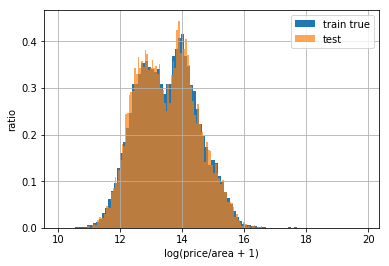

In [53]:
plt.hist(cv['log_parea_total_price'], bins=100, label='train true', normed=True)
plt.hist(np.log1p(test_pred_final['total_price'] / test['building_area']), bins=100, label='test',
         normed=True, alpha=0.7)
plt.xlabel('log(price/area + 1)'); plt.ylabel('ratio')
plt.legend(); plt.grid(); plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


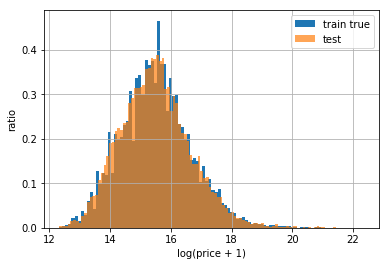

In [54]:
plt.hist(cv['log_total_price'], bins=100, label='train true', normed=True)
plt.hist(np.log1p(test_pred_final['total_price']), bins=100, label='test', normed=True, alpha=0.7)
plt.xlabel('log(price + 1)'); plt.ylabel('ratio')
plt.legend(); plt.grid(); plt.show()